In [1]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
import os
os.chdir(os.path.expanduser('~/wcEcoli'))
import numpy as np
import pandas as pd

In [2]:
# load in the data:
HL_data = "models/ecoli/analysis/local_notebooks/venn_diagram/data/merged_data.csv"
HL_data = pd.read_csv(HL_data)

# read in the other data to get the common names:
common_names = "reconstruction/ecoli/scripts/protein_half_lives/Gupta_et_al_Clim_data/Clim_EcoCyc_monomer_ID_matches/41467_2024_49920_MOESM4_ESM_ST1_EcoCyc_monomer_ID_matches_11202024.tsv"
common_names = pd.read_csv(common_names, sep="\t", header=1)

# go through each id in the HL_data and get the "Common Name" that corresponds to the "Monomer ID"
common_names_dict = {}
for index, row in common_names.iterrows():
    common_names_dict[row["Monomer ID"]] = row["Common Name"]

# add the common names to the HL_data
HL_data["common_name"] = HL_data["id"].map(common_names_dict)

# add complex names to the HL_data
complex_table = "out/complex_classification_tables/all_monomers_sorted.csv"
complex_table = pd.read_csv(complex_table)
complex_names_dict = {}
for index, row in complex_table.iterrows():
    complex_names_dict[row["monomer_id"]] = row["complex_id"]
HL_data["complex_id"] = HL_data["id"].map(complex_names_dict)

# replace all NaN values with "None"
HL_data["complex_id"] = HL_data["complex_id"].fillna("None")
for index, row in HL_data.iterrows():
    if row["complex_id"] == "None":
        HL_data.at[index, "protease_assignment_complex"] = row["protease_assignment"] + " (monomer)"
    else:
        HL_data.at[index, "protease_assignment_complex"] = row["protease_assignment"] + " (complex)"


HL_data

,id,protease_assignment,ClpP,Lon,HslV,Unexplained,degradation_rate(1/s),half_life_(min),degradation_rate_source,average_concentration,standard_deviation,common_name,complex_id,protease_assignment_complex
0,EG10156-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,0.000143,80.656400,Gupta_et_al_MS_2024,3.486383e-06,2.392165e-06,clpA,CPLX0-3108,ClpP only (complex)
1,MDLB-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,0.000022,527.946265,Gupta_et_al_MS_2024,7.175699e-06,1.164671e-05,mdlB,None,ClpP only (monomer)
2,EG10927-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,0.000018,640.789880,Gupta_et_al_MS_2024,3.572458e-07,5.789671e-07,sbcC,CPLX0-3957,ClpP only (complex)
3,EG10618-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,0.000023,498.593755,Gupta_et_al_MS_2024,6.118330e-07,6.525176e-07,mukB,CPLX0-7696,ClpP only (complex)
4,AERGLYC3PDEHYDROG-MONOMER,ClpP only,0.993731,0.000000,0.000000,0.000000,0.000036,322.881971,Gupta_et_al_MS_2024,3.067243e-06,2.146631e-06,glpD,AERGLYC3PDEHYDROG-CPLX,ClpP only (complex)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,EG12690-MONOMER,"Additive: ClpP, Lon, HslV",0.277972,0.277364,0.378556,0.066108,0.000019,596.607579,Gupta_et_al_MS_2024,1.663928e-06,1.402802e-06,rarA,CPLX0-8560,"Additive: ClpP, Lon, HslV (complex)"
78,PD03831,"Additive: ClpP, Lon",0.519958,0.403122,0.000000,0.076920,0.000036,321.351724,Gupta_et_al_MS_2024,2.266592e-07,4.950785e-07,dnaA,None,"Additive: ClpP, Lon (monomer)"
79,AROK-MONOMER,"Additive: ClpP, Lon, HslV",0.319436,0.429511,0.167152,0.083901,0.000035,328.132421,Gupta_et_al_MS_2024,1.181332e-03,2.879909e-04,aroK,None,"Additive: ClpP, Lon, HslV (monomer)"
80,G7263-MONOMER,"Additive: ClpP, Lon, HslV",0.183526,0.206054,0.520932,0.089488,0.000023,512.768046,Gupta_et_al_MS_2024,2.199079e-07,5.048420e-07,murQ,CPLX0-7732,"Additive: ClpP, Lon, HslV (complex)"


In [3]:
# count the number of different assignements in the protease_assignment column and how many times they appear
counts = HL_data['protease_assignment'].value_counts()
counts = counts.to_dict()
counts

{'ClpP only': 40,
 'Additive: ClpP, Lon, HslV': 32,
 'Lon only': 6,
 'Additive: ClpP, Lon': 3,
 'HslV only': 1}

# Donut plot

Code adapted from: https://python-graph-gallery.com/donut-plot/

Pros: easy to see

Cons: cannot put the #s on the chart itself, which might be nice (could just add it as brackets tho

Future things to explore: maybe split up more, into having a each pie slice have a lighter shade in it to represent monomers vs the darker shade representing complexes.

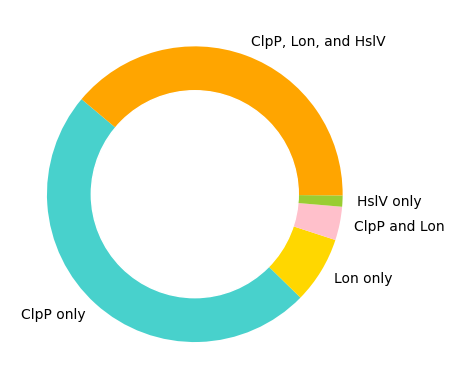

In [4]:
# library
import matplotlib.pyplot as plt

# create data
size_of_groups=[40, 6, 3, 1, 32]
# create data
names = ['ClpP only', 'Lon only', 'ClpP and Lon', 'HslV only', 'ClpP, Lon, and HslV']
colors = ['mediumturquoise','gold','pink','yellowgreen', 'orange']
# Create a pieplot
plt.pie(size_of_groups, labels=names, colors=colors, startangle=140, )

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')

p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()


# priority substrate data plots

# prep data

In [9]:
current_sequence = "CLClim3NE1"
CLNE_sequence = "CLNE_11192024"

In [5]:
# read in the unfiltered data:
CLClimNE_log_data_with_proteases = pd.read_csv('out/CLClim3NE1/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')

# remove the last three characters from each entry in the Monomer ID column:
CLClimNE_log_data_with_proteases['Monomer ID'] = CLClimNE_log_data_with_proteases['Monomer ID'].str[:-3]
CLClimNE_log_data_with_proteases

,Monomer ID,Log10 Average Monomer Counts
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,2.239675
1,1-PFK-MONOMER,1.747600
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,2.321794
3,2-ISOPROPYLMALATESYN-MONOMER,3.482980
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,2.695617
...,...,...
4305,YTFR-MONOMER,1.180822
4306,YTFT-MONOMER,1.138950
4307,ZNUA-MONOMER,2.872238
4308,ZNUB-MONOMER,1.829640


In [6]:
# add the gene names:
common_names = "reconstruction/ecoli/scripts/protein_half_lives/Gupta_et_al_Clim_data/Clim_EcoCyc_monomer_ID_matches/41467_2024_49920_MOESM4_ESM_ST1_EcoCyc_monomer_ID_matches_11202024.tsv"
common_names = pd.read_csv(common_names, sep='\t', skiprows=1)
# read in the priority protease data:
priority_substrates = "models/ecoli/analysis/local_notebooks/protease_substrate_relationships/data/priority_protease_assignments_0.tsv"
priority_substrates = pd.read_csv(priority_substrates, sep='\t', skiprows=1)
# add the CLim3 HL source:
CLClim3NE1_HLs = "out/CLClim3NE1/kb_plot_out/protein_half_lives.tsv"
CLClim3NE1_HLs = pd.read_csv(CLClim3NE1_HLs, sep='\t')

# add the protease assginment
CLClimNE_log_data_with_proteases['protease assignment'] = "NA"
for index, row in CLClimNE_log_data_with_proteases.iterrows():
    if row['Monomer ID'] in priority_substrates['id'].values:
        CLClimNE_log_data_with_proteases.at[index, 'protease assignment'] = priority_substrates[priority_substrates['id'] == row['Monomer ID']]['protease_assignment'].values[0]

# add the gene symbol
CLClimNE_log_data_with_proteases['gene symbol'] = None
for index, row in CLClimNE_log_data_with_proteases.iterrows():
    if row['Monomer ID'] in common_names['Monomer ID'].values:
        CLClimNE_log_data_with_proteases.at[index, 'gene symbol'] = common_names[common_names['Monomer ID'] == row['Monomer ID']]['Common Name'].values[0]

# add in the HL source:
CLClimNE_log_data_with_proteases['HL source'] = None
CLClimNE_log_data_with_proteases['HL value'] = None
for index, row in CLClimNE_log_data_with_proteases.iterrows():
    if row['Monomer ID'] in CLClim3NE1_HLs['monomer_id'].values:
        CLClimNE_log_data_with_proteases.at[index, 'HL source'] = CLClim3NE1_HLs[CLClim3NE1_HLs['monomer_id'] == row['Monomer ID']]['degradation_rate_source'].values[0]
        CLClimNE_log_data_with_proteases.at[index, 'HL value'] = CLClim3NE1_HLs[CLClim3NE1_HLs['monomer_id'] == row['Monomer ID']]['half_life_(min)'].values[0]


# add the half life source in the Clim3 data:
# todo actually there is only so much that can be in the hover data, see if this can be added too

CLClimNE_log_data_with_proteases

,Monomer ID,Log10 Average Monomer Counts,protease assignment,gene symbol,HL source,HL value
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,2.239675,NA,plsC,Gupta_et_al_MS_2024,501.707893
1,1-PFK-MONOMER,1.747600,NA,fruK,Gupta_et_al_MS_2024,766.256894
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,2.321794,NA,panE,N_end_rule,600.0
3,2-ISOPROPYLMALATESYN-MONOMER,3.482980,NA,leuA,Gupta_et_al_MS_2024,276.924332
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,2.695617,NA,ubiE,Gupta_et_al_MS_2024,493.39705
...,...,...,...,...,...,...
4305,YTFR-MONOMER,1.180822,NA,ytfR,Gupta_et_al_MS_2024,654.149344
4306,YTFT-MONOMER,1.138950,NA,ytfT,N_end_rule,600.0
4307,ZNUA-MONOMER,2.872238,NA,znuA,Gupta_et_al_MS_2024,638.129701
4308,ZNUB-MONOMER,1.829640,NA,None,N_end_rule,600.0


In [7]:
# figure out which proteins were assigned to lon in the model:
lon_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'Lon only']
lon_proteins

# figure out which proteins were assigned to clp in the model:
clp_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'ClpP only']

hslv_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'HslV only']

# figure out which proteins are additive in the model:
additive_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'Additive: ClpP, Lon']

# figure out which proteins are redundant in the model:
redundant_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'Additive: ClpP, Lon, HslV']



# figure out which proteins were not assigned to a protease in the model:
no_protease_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'NA']

# todo: note that these numbers will not add up to those in the graph below bc some proteins in the CLClim0NE model are not in the CLNE model
#298 total
print("Lon Proteins(" +str(len(lon_proteins))+"): ", list(lon_proteins['gene symbol'])) #14
print("ClpP Proteins(" +str(len(clp_proteins))+"): ", list(clp_proteins['gene symbol'])) #63
print("HslV Proteins(" +str(len(hslv_proteins))+"): ", list(hslv_proteins['gene symbol'])) #1
print("Additive Proteins: Lon, ClpP (" +str(len(additive_proteins))+"): ", list(additive_proteins['gene symbol'])) #79
print("Additive: Lon, ClpP, HslV Proteins(" +str(len(redundant_proteins))+"): ", list(redundant_proteins['gene symbol'])) #39
#print("No Protease Proteins(" +str(len(no_protease_proteins))+"): ", list(no_protease_proteins['gene symbol'])) # 4012

# ClpP does not have

Lon Proteins(6):  ['ydcI', 'nemA', 'fhlA', 'metR', 'trxC', 'rpoD']
ClpP Proteins(40):  ['fadE', 'glpD', 'cysD', 'ribB', 'clpA', 'clpX', 'dksA', 'dnaB', 'dnaK', 'ftsZ', 'mukB', 'mutS', 'nfo', 'parC', 'pcnB', 'recA', 'rpsA', 'sbcC', 'uvrD', 'dps', 'def', 'phoH', 'intA', 'rutA', 'comR', 'ydhQ', 'yfcZ', 'patA', 'obgE', 'yheO', 'lldD', 'mdlB', 'oxyR', 'exuR', 'putA', 'rpoB', 'rpoC', 'rpoS', 'yheS', 'znuC']
HslV Proteins(1):  ['uhpA']
Additive Proteins: Lon, ClpP (3):  ['ibpA', 'grcA', 'dnaA']
Additive: Lon, ClpP, HslV Proteins(32):  ['aroK', 'helD', 'ligA', 'minE', 'parE', 'pspA', 'rhlB', 'srmB', 'ybaB', 'yibA', 'mazF', 'yjgA', 'yihD', 'yiiQ', 'yiaU', 'yfhH', 'erpA', 'ppiC', 'glaR', 'chaB', 'rarA', 'proQ', 'acpP', 'ycaR', 'hprR', 'murQ', 'iscR', 'kbp', 'yggX', 'glnD', 'yaeP', 'thiL']


In [10]:
# prepare the data for a plot:
CLClimNE_log_data_with_proteases = CLClimNE_log_data_with_proteases.copy()

CLNE_log_data = pd.read_csv('/Users/miagrahn/wcEcoli/out/CLNE_11192024/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLNE_log_data['Monomer ID'] = CLNE_log_data['Monomer ID'].str[:-3]

# merge the two dataframes:
CLNE_new_name = "Log10 " +CLNE_sequence +" Average Monomer Counts"
CLClimNE_new_name = "Log10 " +current_sequence +" Average Monomer Counts"

CLNE_log_data = CLNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLNE_new_name})
CLClimNE_log_data_with_proteases = CLClimNE_log_data_with_proteases.rename(columns={"Log10 Average Monomer Counts": CLClimNE_new_name})
#CLNE_log_data = CLNE_log_data[["Monomer ID", "Log10 CLNE Protein Counts"]]
#CLClimNE_log_data_with_proteases = CLClimNE_log_data_with_proteases[["Monomer ID", "Log10 CLClim0NE Protein Counts"]]
CLNE_log_data = CLNE_log_data.set_index("Monomer ID")
CLClimNE_log_data_with_proteases = CLClimNE_log_data_with_proteases.set_index("Monomer ID")
CLNE_CLClimNE_log_data_proteases = CLNE_log_data.join(CLClimNE_log_data_with_proteases, how="inner")
CLNE_CLClimNE_log_data_proteases = CLNE_CLClimNE_log_data_proteases.reset_index()

# make a copy of the CLClimNE_log_data_with_proteases data:
CLClimNE_log_data_with_Lon_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Clp_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_HslV_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Additive_LC = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Additive_LCH = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_no_protease_proteases = CLNE_CLClimNE_log_data_proteases.copy()

# remove the proteins that were not assigned to the protease in the model:
CLClimNE_log_data_with_Lon_proteases = CLClimNE_log_data_with_Lon_proteases[CLClimNE_log_data_with_Lon_proteases['protease assignment'] == 'Lon only']
CLClimNE_log_data_with_Clp_proteases = CLClimNE_log_data_with_Clp_proteases[CLClimNE_log_data_with_Clp_proteases['protease assignment'] == 'ClpP only']
CLClimNE_log_data_with_HslV_proteases = CLClimNE_log_data_with_HslV_proteases[CLClimNE_log_data_with_HslV_proteases['protease assignment'] == 'HslV only']
CLClimNE_log_data_with_Additive_LC_proteases = CLClimNE_log_data_with_Additive_LC[CLClimNE_log_data_with_Additive_LC['protease assignment'] == 'Additive: ClpP, Lon']
CLClimNE_log_data_with_Additive_LCH_proteases = CLClimNE_log_data_with_Additive_LCH[CLClimNE_log_data_with_Additive_LCH['protease assignment'] == 'Additive: ClpP, Lon, HslV']
CLClimNE_log_data_with_no_protease_proteases = CLClimNE_log_data_with_no_protease_proteases[CLClimNE_log_data_with_no_protease_proteases['protease assignment'] == 'NA']


also tag proteins by their degredation rate:

In [11]:
# todo: should I calculate the log2 fold change?

# calculate the fold change between the log counts of CLNE and CLClim3NE:
CLNE_CLClimNE_log_data_proteases['protein_fold_change'] = 10**(CLNE_CLClimNE_log_data_proteases[CLClimNE_new_name]) / 10**(CLNE_CLClimNE_log_data_proteases[CLNE_new_name])
# calculate the log2 fold change between the log counts of CLNE and CLClim3NE:
CLNE_CLClimNE_log_data_proteases['log2_fold_change'] = np.log2(CLNE_CLClimNE_log_data_proteases['protein_fold_change'])
# calculate the log10 fold change between the log counts of CLNE and CLClim3NE:
CLNE_CLClimNE_log_data_proteases['log10_fold_change'] = np.log10(CLNE_CLClimNE_log_data_proteases['protein_fold_change'])

# find the proteins that had a difference of less than -400:
largest_change = CLNE_CLClimNE_log_data_proteases[(CLNE_CLClimNE_log_data_proteases['HL value'] < 50) & (CLNE_CLClimNE_log_data_proteases['HL source'] == 'Gupta_et_al_MS_2024')]


largest_change = largest_change.sort_values(by="HL value", ascending=True) # I think it is already sorted by difference
largest_change

,Monomer ID,Log10 CLNE_11192024 Average Monomer Counts,Log10 CLClim3NE1 Average Monomer Counts,protease assignment,gene symbol,HL source,HL value,protein_fold_change,log2_fold_change,log10_fold_change
3862,PD03867,1.731011,0.053854,NA,rbsR,Gupta_et_al_MS_2024,0.708811,0.021030,-5.571395,-1.677157
1649,EG50004-MONOMER,4.419169,3.487947,NA,rmf,Gupta_et_al_MS_2024,6.165352,0.117160,-3.093451,-0.931221
48,ADHP-MONOMER,2.662772,2.597600,NA,adhP,Gupta_et_al_MS_2024,8.867585,0.860654,-0.216495,-0.065172
2422,G6988-MONOMER,0.975811,0.170686,NA,yeaW,Gupta_et_al_MS_2024,10.906607,0.156630,-2.674565,-0.805124
980,EG11389-MONOMER,3.490012,2.712679,NA,fliT,Gupta_et_al_MS_2024,11.469439,0.166981,-2.582243,-0.777333
2865,G7568-MONOMER,2.135373,1.173960,NA,ygiQ,Gupta_et_al_MS_2024,12.335229,0.109292,-3.193745,-0.961413
1159,EG11734-MONOMER,2.742356,1.942295,ClpP only,phoH,Gupta_et_al_MS_2024,12.410689,0.158467,-2.657745,-0.800061
979,EG11388-MONOMER,3.495836,2.778650,NA,fliS,Gupta_et_al_MS_2024,13.660143,0.191785,-2.382441,-0.717186
2415,G6980-MONOMER,2.379748,1.675820,NA,dgcP,Gupta_et_al_MS_2024,13.955536,0.197730,-2.338399,-0.703928
2079,G6549-MONOMER,2.878943,2.224129,NA,ymdA,Gupta_et_al_MS_2024,15.376756,0.221405,-2.175242,-0.654813


In [38]:
names = ['ClpP only', 'Lon only', 'ClpP and Lon', 'HslV only', 'ClpP, Lon, and HslV']
colors = ['mediumturquoise','gold','pink','yellowgreen', 'orange']

# make a color dictionary for the protease assignment:
color_dict = {
    'ClpP only': 'mediumturquoise',
    'Lon only': 'gold',
    'ClpP and Lon': 'pink',
    'HslV only': 'yellowgreen',
    'ClpP, Lon, and HslV': 'orange',
    'Additive: ClpP, Lon': 'pink',
    'Additive: ClpP, Lon, HslV': 'red',
    'NA': 'grey'
}

color_dict = {
    'ClpP only': 'mediumturquoise',
    'Lon only': 'gold',
    'HslV only': 'yellowgreen',
    'Additive: ClpP, Lon': 'pink',
    'Additive: ClpP, Lon, HslV': 'orange',
    'NA': 'grey'
}


In [12]:
import seaborn as sns
# make a copy of the data:
priority_substrates = CLNE_CLClimNE_log_data_proteases.copy()

# remove the proteins that were not assigned to the protease in the model:
priority_substrates = priority_substrates[priority_substrates['protease assignment'] != 'NA']

priority_substrates





,Monomer ID,Log10 CLNE_11192024 Average Monomer Counts,Log10 CLClim3NE1 Average Monomer Counts,protease assignment,gene symbol,HL source,HL value,protein_fold_change,log2_fold_change,log10_fold_change
37,ACYLCOADEHYDROG-MONOMER,1.426334,1.137880,ClpP only,fadE,Gupta_et_al_MS_2024,195.40524,0.514690,-0.958224,-0.288454
49,AERGLYC3PDEHYDROG-MONOMER,3.967751,3.993769,ClpP only,glpD,Gupta_et_al_MS_2024,322.881971,1.061741,0.086431,0.026018
113,AROK-MONOMER,3.053324,3.027640,"Additive: ClpP, Lon, HslV",aroK,Gupta_et_al_MS_2024,328.132421,0.942577,-0.085318,-0.025683
284,CYSD-MONOMER,3.084746,3.016763,ClpP only,cysD,Gupta_et_al_MS_2024,179.116561,0.855098,-0.225838,-0.067984
330,DIOHBUTANONEPSYN-MONOMER,2.929821,2.847344,ClpP only,ribB,Gupta_et_al_MS_2024,86.548614,0.827033,-0.273983,-0.082477
...,...,...,...,...,...,...,...,...,...,...
4006,RPOS-MONOMER,3.342147,3.075373,ClpP only,rpoS,Gupta_et_al_MS_2024,61.592381,0.541037,-0.886202,-0.266773
4072,THI-P-KIN-MONOMER,2.039914,2.168524,"Additive: ClpP, Lon, HslV",thiL,Gupta_et_al_MS_2024,656.519837,1.344651,0.427232,0.128610
4143,UHPA-MONOMER,1.998154,1.767486,HslV only,uhpA,Gupta_et_al_MS_2024,547.850261,0.587939,-0.766261,-0.230668
4244,YHES-MONOMER,2.230563,2.100950,ClpP only,yheS,Gupta_et_al_MS_2024,392.18553,0.741971,-0.430566,-0.129613


## half lives

In [26]:
# HL data only:
data_HL = priority_substrates[['gene symbol', 'HL value', 'protease assignment']]
data_HL.set_index('gene symbol', inplace=True)
# sort the data by the HL value:
data_HL = data_HL.sort_values(by='HL value', ascending=True)

data_HL

,HL value,protease assignment
gene symbol,,
phoH,12.410689,ClpP only
rpoS,61.592381,ClpP only
intA,78.816019,ClpP only
metR,79.151002,Lon only
clpA,80.6564,ClpP only
...,...,...
hprR,656.623355,"Additive: ClpP, Lon, HslV"
oxyR,668.719267,ClpP only
rpoB,671.612279,ClpP only


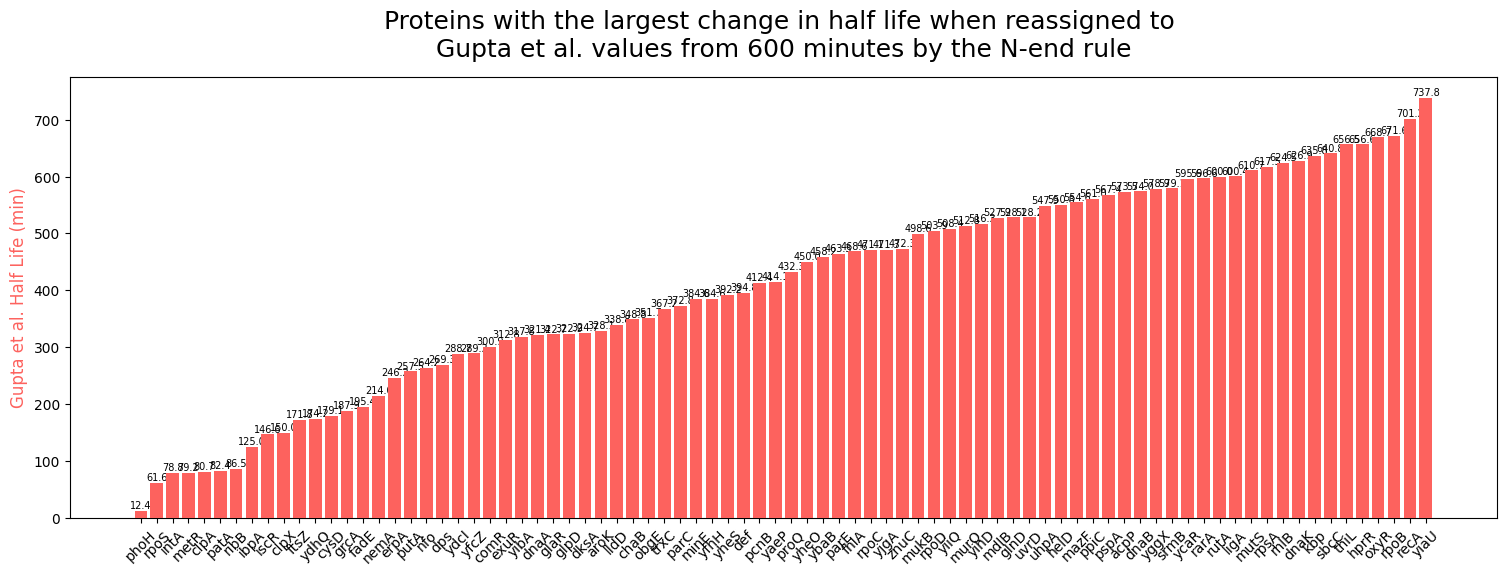

In [28]:
# make a bar plot of the half lives by the common names and color them by protease assignement:


font_color = '#525252'
hfont = {'fontname':'Calibri'}
#facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data_HL.index
column0 = data_HL['HL value']
title0 = 'Proteins with the largest change in half life when reassigned to \nGupta et al. values from 600 minutes by the N-end rule'

fig, axes = plt.subplots(figsize=(15,5),  nrows=1, )
fig.tight_layout()

axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )
for i, val in enumerate(column0):
    axes.text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )

axes.set(xticks=data_HL.index, xticklabels=data_HL.index)
for tick in axes.get_xticklabels():
    tick.set_rotation(45)

axes.set_ylabel('Gupta et al. Half Life (min)', fontsize=12, color=color_red, )

#plt.subplots_adjust(hspace=0, top=1.2, bottom=0, left=0.18, right=0.95)

# # save the figure:
# out_pth = "out/figures/PDR_UPDATE_MERGE/Clim3_related/plots_under_the_donut/plots_under_the_donut_HLs_only.png"
# out_pth = os.path.expanduser(out_pth)
# output_dir = os.path.dirname(out_pth)
# os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
# plt.savefig(out_pth, dpi=300, bbox_inches='tight')

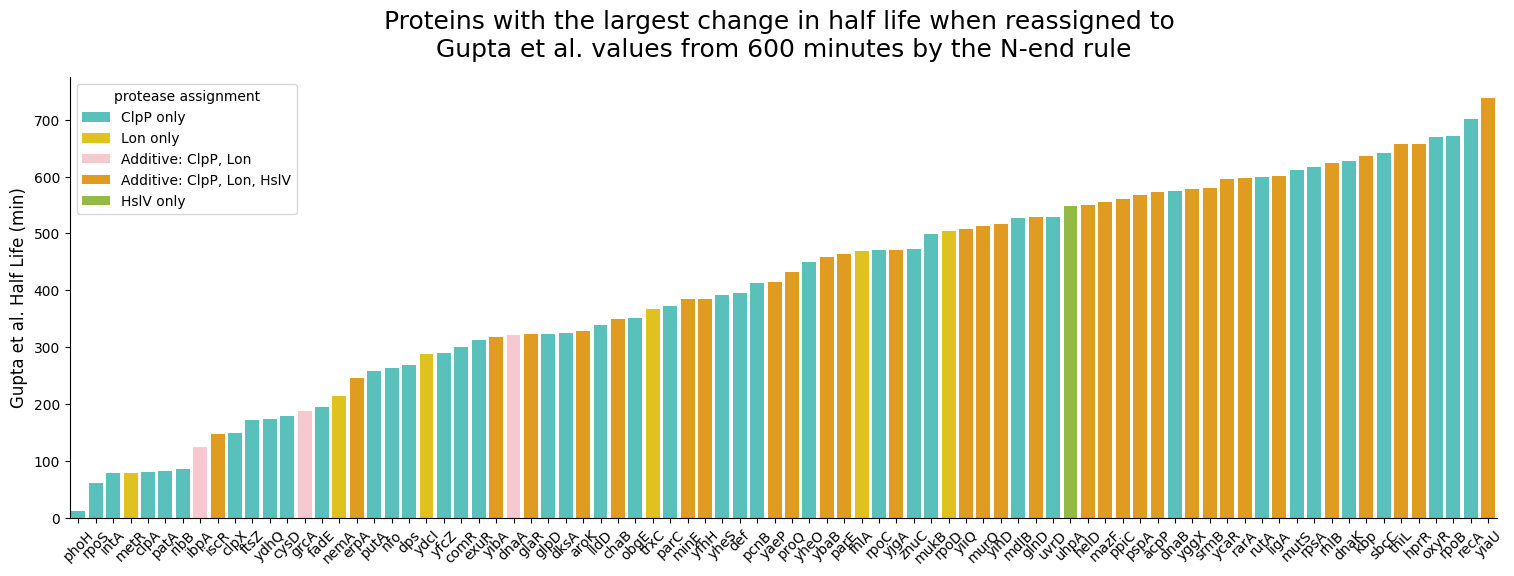

In [54]:
#https://stackoverflow.com/questions/68616781/customizing-the-hue-colors-used-in-seaborn-barplot
#https://stackoverflow.com/questions/72444622/how-to-set-different-colors-on-matplotlib-bar-graph-based-on-the-group-of-data

fig, axes = plt.subplots(figsize=(15,5),  nrows=1, )
fig.tight_layout()


sns.barplot(x='gene symbol', y='HL value', data=data_HL, hue='protease assignment', palette=color_dict, dodge=False)
plt.xticks(rotation=45)
plt.title(title0, fontsize=18, pad=15, )
plt.ylabel('Gupta et al. Half Life (min)', fontsize=12, )
plt.xlabel('')

#for i, val in enumerate(column0):
    #axes.text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )

# remove the top and right spines:
axes.spines[['right', 'top']].set_visible(False) #https://stackoverflow.com/questions/925024/how-can-i-remove-the-top-and-right-axis


# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/Clim3_related/plots_under_the_donut/plots_under_the_donut_HLs_only.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

In [ ]:
# todo: consider adding one that is the new and old average monomer counts together

## protease fraction

In [ ]:
# todo: consider having this be a dual y axis plot..... ahhhhh! where there is a line per type of protease contribution (ie Clp, Lon, HslV, and unexplained) in different colors so we can see the contribution of each? OR have a y axis be fraction of protease contribution unexplained and then have the lower y axis be the contributions from the other sources. have the fraction unexplained be the same color as the key above?

# todo: could also do a fold change graph, with fold change on one side, then the two different protein counts on the other side

# todo: still do a sock plot version of both?

# might be helpful bc there are outlines: https://stackoverflow.com/questions/12862529/alternate-colors-in-stacked-matplotlib-bar

# method 1:
# have the original color coded plot.

# for the compoenent plot, have them in the same order and all the same height, just broken up by different assignment colors


# method 2:
# the HL plot just has outlines of the respective colors and then is a sock plot with the complex fractions within it. kill two birds with one stone

In [55]:
HL_data

,id,protease_assignment,ClpP,Lon,HslV,Unexplained,degradation_rate(1/s),half_life_(min),degradation_rate_source,average_concentration,standard_deviation,common_name,complex_id,protease_assignment_complex
0,EG10156-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,0.000143,80.656400,Gupta_et_al_MS_2024,3.486383e-06,2.392165e-06,clpA,CPLX0-3108,ClpP only (complex)
1,MDLB-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,0.000022,527.946265,Gupta_et_al_MS_2024,7.175699e-06,1.164671e-05,mdlB,None,ClpP only (monomer)
2,EG10927-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,0.000018,640.789880,Gupta_et_al_MS_2024,3.572458e-07,5.789671e-07,sbcC,CPLX0-3957,ClpP only (complex)
3,EG10618-MONOMER,ClpP only,1.000000,0.000000,0.000000,0.000000,0.000023,498.593755,Gupta_et_al_MS_2024,6.118330e-07,6.525176e-07,mukB,CPLX0-7696,ClpP only (complex)
4,AERGLYC3PDEHYDROG-MONOMER,ClpP only,0.993731,0.000000,0.000000,0.000000,0.000036,322.881971,Gupta_et_al_MS_2024,3.067243e-06,2.146631e-06,glpD,AERGLYC3PDEHYDROG-CPLX,ClpP only (complex)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,EG12690-MONOMER,"Additive: ClpP, Lon, HslV",0.277972,0.277364,0.378556,0.066108,0.000019,596.607579,Gupta_et_al_MS_2024,1.663928e-06,1.402802e-06,rarA,CPLX0-8560,"Additive: ClpP, Lon, HslV (complex)"
78,PD03831,"Additive: ClpP, Lon",0.519958,0.403122,0.000000,0.076920,0.000036,321.351724,Gupta_et_al_MS_2024,2.266592e-07,4.950785e-07,dnaA,None,"Additive: ClpP, Lon (monomer)"
79,AROK-MONOMER,"Additive: ClpP, Lon, HslV",0.319436,0.429511,0.167152,0.083901,0.000035,328.132421,Gupta_et_al_MS_2024,1.181332e-03,2.879909e-04,aroK,None,"Additive: ClpP, Lon, HslV (monomer)"
80,G7263-MONOMER,"Additive: ClpP, Lon, HslV",0.183526,0.206054,0.520932,0.089488,0.000023,512.768046,Gupta_et_al_MS_2024,2.199079e-07,5.048420e-07,murQ,CPLX0-7732,"Additive: ClpP, Lon, HslV (complex)"


In [58]:
# HL data only:
data_PF = HL_data[['common_name', 'half_life_(min)', 'protease_assignment', 'ClpP', 'Lon', 'HslV', 'Unexplained']]
data_PF.set_index('common_name', inplace=True)
# sort the data by the HL value:
data_PF = data_PF.sort_values(by='half_life_(min)', ascending=True)

data_PF

,half_life_(min),protease_assignment,ClpP,Lon,HslV,Unexplained
common_name,,,,,,
phoH,12.410689,ClpP only,0.711802,0.000000,0.000000,0.004317
rpoS,61.592381,ClpP only,0.735729,0.226135,0.000000,0.038135
intA,78.816019,ClpP only,0.904207,0.000000,0.000000,0.045293
metR,79.151002,Lon only,0.274098,0.691488,0.000000,0.034414
clpA,80.656400,ClpP only,1.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
hprR,656.623355,"Additive: ClpP, Lon, HslV",0.243273,0.281768,0.447599,0.027361
oxyR,668.719267,ClpP only,0.779535,0.036100,0.184364,0.000000
rpoB,671.612279,ClpP only,0.730978,0.269022,0.000000,0.000000


Text(0, 0.5, 'Pies Consumed')

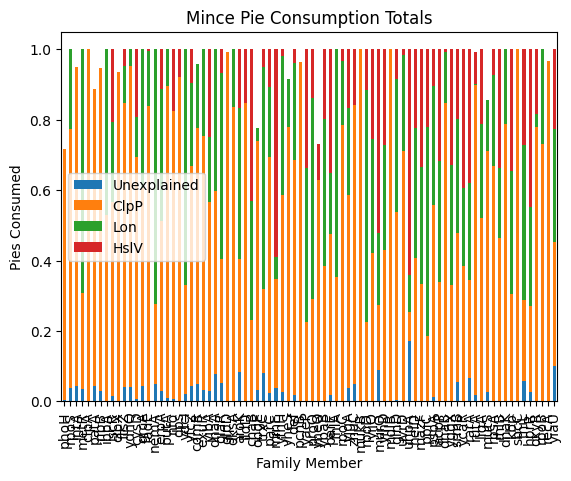

In [69]:
# from here: https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

# Choose columns in the order to "stack" them
data_PF[['Unexplained',"ClpP", "Lon", "HslV"]].plot(kind="bar", stacked=True)
plt.title("Mince Pie Consumption Totals")
plt.xlabel("Family Member")
plt.ylabel("Pies Consumed")

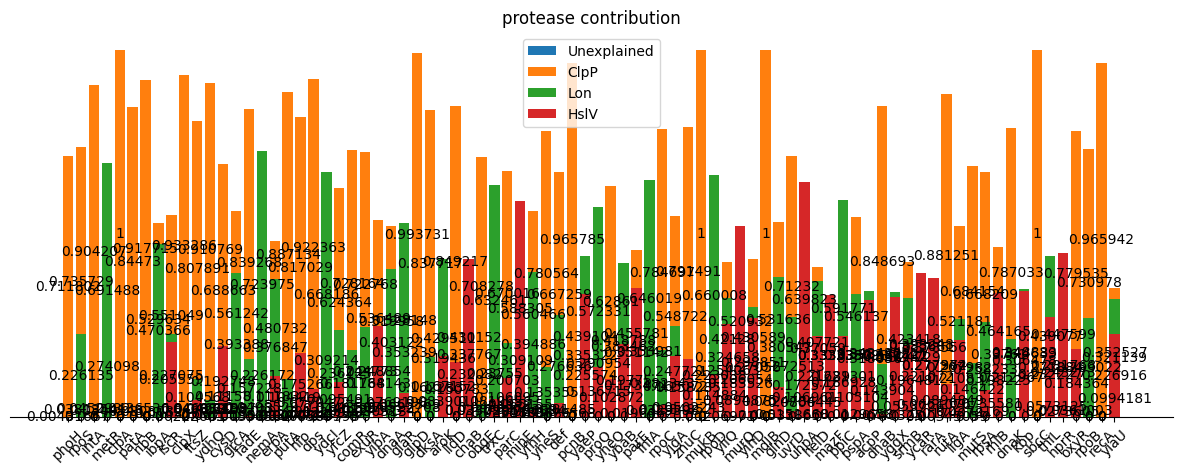

In [96]:
# from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html

fig, ax = plt.subplots(figsize=(15,5),  nrows=1,)
bottom = np.zeros(len(data_PF))

ClpP = data_PF['ClpP'].values
Lon = data_PF['Lon'].values
HslV = data_PF['HslV'].values
Unexplained = data_PF['Unexplained'].values

compostions = {
    'Unexplained': Unexplained,
    'ClpP': ClpP,
    'Lon': Lon,
    'HslV': HslV
}

width = 0.8
names = list(data_PF.index)

for substrate, substrate_count in compostions.items():
    p = ax.bar(names, substrate_count, width, label=substrate, )
    bottom += substrate_count

    ax.bar_label(p, label_type='center')

ax.set_title('protease contribution')
plt.tick_params(axis='y', left=False)
plt.xticks(rotation=45)

ax.yaxis.set_ticks([])

ax.legend()

# remove the top and right spines:
ax.spines[['right', 'top', 'left']].set_visible(False) #https://stackoverflow.com/questions/925024/how-can-i-remove-the-top-and-right-axis



# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/Clim3_related/plots_under_the_donut/plots_under_the_donut_protease_contribution.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')
# todo: something is wrong bc they should be all close to the same height

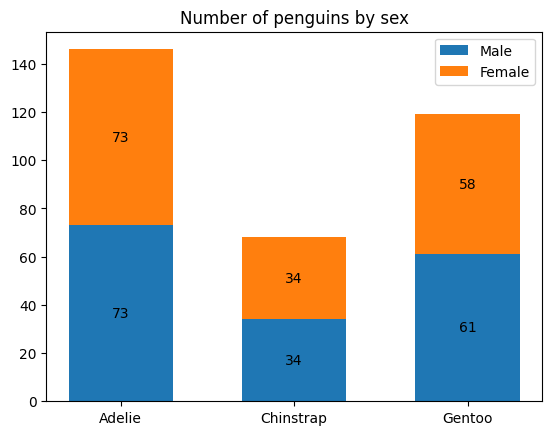

In [76]:
species = ('Adelie', 'Chinstrap', 'Gentoo')
sex_counts = {
    'Male': np.array([73, 34, 61]),
    'Female': np.array([73, 34, 58]),
}
width = 0.6  # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots()
bottom = np.zeros(3)

for sex, sex_count in sex_counts.items():
    p = ax.bar(species, sex_count, width, label=sex, bottom=bottom)
    bottom += sex_count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of penguins by sex')
ax.legend()

plt.show()

In [82]:
fig, ax = plt.subplots()
bottom = np.zeros(len(data_PF))

ClpP = data_PF['ClpP'].values
Lon = data_PF['Lon'].values
HslV = data_PF['HslV'].values
Unexplained = data_PF['Unexplained'].values

compositions = {
    'Unexplained': Unexplained,
    'ClpP': ClpP,
    'Lon': Lon,
    'HslV': HslV
}

width = 0.8
names = list(data_PF.index)

for substrate, substrate_count in compositions.items():
    p = ax.bar(names, substrate_count, width, label=substrate, bottom=bottom)
    bottom += substrate_count
    ax.bar_label(p, label_type='center')

ax.set_title('Protease Contributions per Substrate')
ax.set_ylabel('Count')
ax.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


RuntimeError: Unknown return type

Error in callback <function _draw_all_if_interactive at 0x174f15d00> (for post_execute):


RuntimeError: Unknown return type

RuntimeError: Unknown return type

<Figure size 640x480 with 1 Axes>

In [86]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# Ensure `bottom` matches number of bars
bottom = np.zeros(len(data_PF))

compositions = {
    'Unexplained': data_PF['Unexplained'].values,
    'ClpP': data_PF['ClpP'].values,
    'Lon': data_PF['Lon'].values,
    'HslV': data_PF['HslV'].values
}

width = 0.8
names = list(data_PF.index.astype(str))  # ensure the index is str for labeling

# Plot and label each stack
for label, values in compositions.items():
    bars = ax.bar(names, values, width, label=label, bottom=bottom)
    bottom += values

    try:
        ax.bar_label(bars, label_type='center')
    except Exception as e:
        print(f"Could not add bar labels for {label}: {e}")

# Title, legend, and formatting
ax.set_title('Protease Contributions per Substrate')
ax.set_ylabel('Count')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


RuntimeError: Unknown return type

Error in callback <function _draw_all_if_interactive at 0x174f15d00> (for post_execute):


RuntimeError: Unknown return type

RuntimeError: Unknown return type

<Figure size 640x480 with 1 Axes>